In [17]:
import sys
sys.path.append(r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis")

In [19]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import flexynesis
import torch
torch.set_num_threads(4)

Seed set to 42


In [20]:
# 四个数据集
import inspect
from flexynesis import DataImporter
import time


print(inspect.getfile(DataImporter))

from flexynesis import DataImporter

data_importer = DataImporter(
    path=r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM1",
    data_types=['LD', 'PM', 'BM', 'HDF'],  # 四个数据集的名称，要和文件名对应
    concatenate=False,  # 根据你需求决定是否合并特征，通常False
    top_percentile=100,  # Laplacian选出前10%特征
    min_features=100,   # 至少保留100个特征
    variance_threshold=0.0,  # 80%的方差阈值
    # correlation_threshold=0.9,  # 如果需要可以打开
)

train_dataset, test_dataset, whole_dataset = data_importer.import_data()


C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\flexynesis\data.py

[INFO] ================= Importing Data =================
[INFO] Validating data folders...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM1\train\clin.csv...
[INFO] Importing C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM1\train\LD.csv...
[INFO] Importing C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM1\train\HDF.csv...
[INFO] Importing C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM1\train\BM.csv...
[INFO] Importing C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM1\train\PM.csv...

[INFO] ------------

<Figure size 800x300 with 0 Axes>

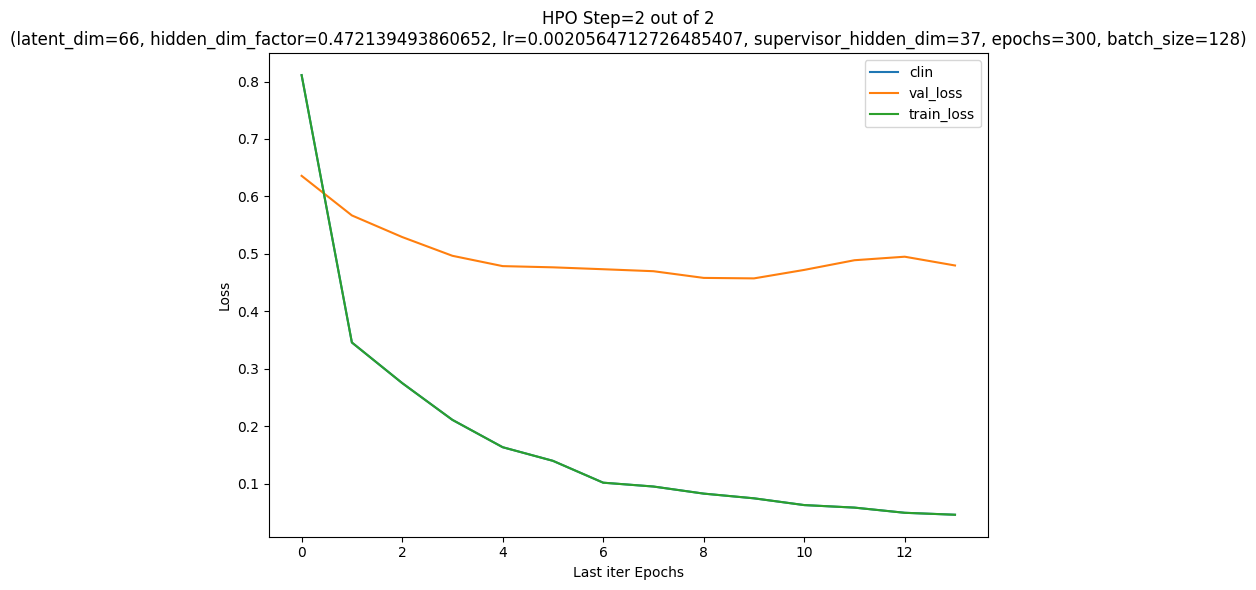

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.4797031581401825     │
│         val_loss          │    0.4797031581401825     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 2/2 [01:14<00:00, 37.48s/it, Iteration=2, Best Loss=0.37]

[INFO] current best val loss: 0.37029653787612915; best params: {'latent_dim': 66, 'hidden_dim_factor': 0.47218182496720706, 'lr': 0.0020352679833429907, 'supervisor_hidden_dim': 37, 'epochs': 300, 'batch_size': 128} since 1 hpo iterations


In [9]:
# early stopping -  tune the best parameters
tuner = flexynesis.HyperparameterTuning(
    dataset = train_dataset,                # training dataset
    model_class = flexynesis.DirectPred,   # model selection
    target_variables = ["clin"],# outcome variable
    config_name = "DirectPred",             
    n_iter=2,                              # how many time the hyperparameters are trained
    plot_losses=True,                      # open the losss ploting function
    early_stop_patience=4                 # if didn't go up  in 4 epochs, stop
)

model, best_params, all_results_df = tuner.perform_tuning()  


In [156]:
import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from captum.attr import IntegratedGradients, GradientShap

def Forward_target(model, *args):
    input_data = list(args[:-2])
    target_var = args[-2]
    steps = args[-1]
    outputs_list = []
    for i in range(steps):
        x_step = [input_data[j][i] for j in range(len(input_data))]
        out = model.forward(x_step)
        outputs_list.append(out[target_var])
    return torch.cat(outputs_list, dim=0)

def compute_class_diff_importance(
    model, 
    dataset, 
    target_var, 
    method="IntegratedGradients", 
    steps_or_samples=5, 
    batch_size=64, 
    device='cpu'
):
    model.to(device)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    if method == "IntegratedGradients":
        explainer = IntegratedGradients(lambda *args: Forward_target(model, *args))
    elif method == "GradientShap":
        explainer = GradientShap(lambda *args: Forward_target(model, *args))
    else:
        raise ValueError(f"Unsupported method '{method}'.")

    if dataset.variable_types[target_var] == 'numerical':
        num_class = 1
    else:
        num_class = len(np.unique([y[target_var] for _, y, _ in dataset]))

    aggregated_attributions = [[] for _ in range(num_class)]
    for batch in dataloader:
        dat, _, _ = batch
        x_list = [dat[x].to(device) for x in dat.keys()]
        input_data = tuple([data.unsqueeze(0).requires_grad_() for data in x_list])

        if method == 'IntegratedGradients':
            baseline = tuple(torch.zeros_like(x) for x in input_data)
        elif method == 'GradientShap':
            baseline = tuple(
                torch.cat([torch.zeros_like(x) for _ in range(steps_or_samples)], dim=0)
                for x in input_data
            )

        for target_class in range(num_class):
            attributions = explainer.attribute(input_data, baseline, 
                                               additional_forward_args=(target_var, steps_or_samples), 
                                               target=target_class,
                                               n_steps=steps_or_samples if method == 'IntegratedGradients' else None,
                                               n_samples=steps_or_samples if method == 'GradientShap' else None)
            aggregated_attributions[target_class].append(attributions)

    layers = list(dataset.dat.keys())
    processed_attributions = []
    for class_idx in range(len(aggregated_attributions)):
        class_attr = aggregated_attributions[class_idx]
        layer_attributions = []
        for layer_idx in range(len(layers)):
            layer_tensors = [batch_attr[layer_idx] for batch_attr in class_attr]
            attr_concat = torch.cat(layer_tensors, dim=1)
            layer_attributions.append(attr_concat)
        processed_attributions.append(layer_attributions)

    attr_cpu = [[a.cpu() for a in attr_class] for attr_class in processed_attributions]
    imp = [[a.mean(dim=1) for a in attr_class] for attr_class in attr_cpu]

    model.to('cpu')
    df_list = []
    for i in range(num_class):
        for j in range(len(layers)):
            features = dataset.features[layers[j]]
            importances = imp[i][j][0].detach().numpy()
            df_list.append(pd.DataFrame({
                'target_variable': target_var,
                'target_class': i,
                'layer': layers[j],
                'name': features,
                'importance': importances
            }))    
    df_imp = pd.concat(df_list, ignore_index=True)

    # === 差值构建 ===
    if num_class == 2:
        df_0 = df_imp[df_imp['target_class'] == 0].copy()
        df_1 = df_imp[df_imp['target_class'] == 1].copy()
        key_cols = ['target_variable', 'layer', 'name']
        df_0 = df_0.set_index(key_cols)
        df_1 = df_1.set_index(key_cols)

        diff_series = df_1['importance'] - df_0['importance']
        diff_abs = diff_series.abs()
        direction = diff_series.apply(lambda x: '↑ class 1' if x > 0 else ('↑ class 0' if x < 0 else 'none'))

        class_diff = pd.DataFrame({
            'target_variable': df_1.index.get_level_values('target_variable'),
            'layer': df_1.index.get_level_values('layer'),
            'name': df_1.index.get_level_values('name'),
            'importance_diff': diff_series,
            'importance_diff_abs': diff_abs,
            'direction': direction
        }).reset_index(drop=True)
    else:
        class_diff = None

    return class_diff


In [157]:
import time
import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from captum.attr import IntegratedGradients, GradientShap
from tqdm import trange  # 用于进度条

# Forward_target 用于 Captum 解释器调用
def Forward_target(model, *args):
    input_data = list(args[:-2])
    target_var = args[-2]
    steps = args[-1]
    outputs_list = []
    for i in range(steps):
        x_step = [input_data[j][i] for j in range(len(input_data))]
        out = model.forward(x_step)
        outputs_list.append(out[target_var])
    return torch.cat(outputs_list, dim=0)

# 计算类别差异的重要性
def compute_class_diff_importance(
    model, 
    dataset, 
    target_var, 
    method="IntegratedGradients", 
    steps_or_samples=5, 
    batch_size=64, 
    device='cpu'
):
    model.to(device)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    if method == "IntegratedGradients":
        explainer = IntegratedGradients(lambda *args: Forward_target(model, *args))
    elif method == "GradientShap":
        explainer = GradientShap(lambda *args: Forward_target(model, *args))
    else:
        raise ValueError(f"Unsupported method '{method}'.")

    if dataset.variable_types[target_var] == 'numerical':
        num_class = 1
    else:
        num_class = len(np.unique([y[target_var] for _, y, _ in dataset]))

    aggregated_attributions = [[] for _ in range(num_class)]
    for batch in dataloader:
        dat, _, _ = batch
        x_list = [dat[x].to(device) for x in dat.keys()]
        input_data = tuple([data.unsqueeze(0).requires_grad_() for data in x_list])

        if method == 'IntegratedGradients':
            baseline = tuple(torch.zeros_like(x) for x in input_data)
        elif method == 'GradientShap':
            baseline = tuple(
                torch.cat([torch.zeros_like(x) for _ in range(steps_or_samples)], dim=0)
                for x in input_data
            )

        for target_class in range(num_class):
            if method == 'IntegratedGradients':
                attributions = explainer.attribute(
                    input_data,
                    baseline,
                    additional_forward_args=(target_var, steps_or_samples), 
                    target=target_class,
                    n_steps=steps_or_samples
                )
            elif method == 'GradientShap':
                attributions = explainer.attribute(
                    input_data,
                    baseline,
                    additional_forward_args=(target_var, steps_or_samples), 
                    target=target_class,
                    n_samples=steps_or_samples
                )
            aggregated_attributions[target_class].append(attributions)

    layers = list(dataset.dat.keys())
    processed_attributions = []
    for class_idx in range(len(aggregated_attributions)):
        class_attr = aggregated_attributions[class_idx]
        layer_attributions = []
        for layer_idx in range(len(layers)):
            layer_tensors = [batch_attr[layer_idx] for batch_attr in class_attr]
            attr_concat = torch.cat(layer_tensors, dim=1)
            layer_attributions.append(attr_concat)
        processed_attributions.append(layer_attributions)

    attr_cpu = [[a.cpu() for a in attr_class] for attr_class in processed_attributions]
    imp = [[a.mean(dim=1) for a in attr_class] for attr_class in attr_cpu]

    model.to('cpu')
    df_list = []
    for i in range(num_class):
        for j in range(len(layers)):
            features = dataset.features[layers[j]]
            importances = imp[i][j][0].detach().numpy()
            df_list.append(pd.DataFrame({
                'target_variable': target_var,
                'target_class': i,
                'layer': layers[j],
                'name': features,
                'importance': importances
            }))    
    df_imp = pd.concat(df_list, ignore_index=True)

    # 差值构建
    if num_class == 2:
        df_0 = df_imp[df_imp['target_class'] == 0].copy()
        df_1 = df_imp[df_imp['target_class'] == 1].copy()
        key_cols = ['target_variable', 'layer', 'name']
        df_0 = df_0.set_index(key_cols)
        df_1 = df_1.set_index(key_cols)

        diff_series = df_1['importance'] - df_0['importance']
        diff_abs = diff_series.abs()
        direction = diff_series.apply(lambda x: '↑ class 1' if x > 0 else ('↑ class 0' if x < 0 else 'none'))

        class_diff = pd.DataFrame({
            'target_variable': df_1.index.get_level_values('target_variable'),
            'layer': df_1.index.get_level_values('layer'),
            'name': df_1.index.get_level_values('name'),
            'importance_diff': diff_series,
            'importance_diff_abs': diff_abs,
            'direction': direction
        }).reset_index(drop=True)
    else:
        class_diff = None

    return class_diff

# 主函数：Permutation test with diff importance
def feature_importance_permutation_test_diff(
    model,
    whole_dataset,
    target_var="clin",
    method="GradientShap",
    steps_or_samples=10,
    batch_size=32,
    n_permutations=200,
    model_class=None,            # 传 None 时需手动传入
    config_name="DirectPred",
    early_stop_patience=4,
    n_iter=2,
    compute_class_diff_fn=compute_class_diff_importance
):
    start_time = time.time()
    print(f"[INFO] Permutation test started at {time.strftime('%Y-%m-%d %H:%M:%S')}")

    # 1. 计算原始差异和方向
    class_diff_obs = compute_class_diff_fn(
        model, whole_dataset, target_var, method, steps_or_samples, batch_size
    )
    obs_diff = class_diff_obs.set_index('name')['importance_diff']
    obs_diff_abs = class_diff_obs.set_index('name')['importance_diff_abs']
    direction = class_diff_obs.set_index('name')['direction']

    # 初始化存储 permutation 结果的 DataFrame
    all_perm_signed = pd.DataFrame(index=obs_diff.index)
    all_perm_abs = pd.DataFrame(index=obs_diff.index)

    # 备份原始标签
    y_orig = whole_dataset.ann[target_var].clone()
    n = len(y_orig)

    for i in trange(n_permutations, desc="Permutations"):
        idx = torch.randperm(n)
        whole_dataset.ann[target_var] = y_orig[idx]

        tuner = flexynesis.HyperparameterTuning(
            dataset=whole_dataset,
            model_class=model_class,
            target_variables=[target_var],
            config_name=config_name,
            n_iter=n_iter,
            plot_losses=False,
            early_stop_patience=early_stop_patience,
        )
        perm_model, _ , _ = tuner.perform_tuning()

        class_diff_perm = compute_class_diff_fn(
            perm_model, whole_dataset, target_var, method, steps_or_samples, batch_size
        )

        perm_signed = class_diff_perm.set_index('name')['importance_diff']
        perm_abs = class_diff_perm.set_index('name')['importance_diff_abs']

        perm_signed = perm_signed.reindex(obs_diff.index).fillna(0)
        perm_abs = perm_abs.reindex(obs_diff_abs.index).fillna(0)

        all_perm_signed[f"perm_{i}"] = perm_signed
        all_perm_abs[f"perm_{i}"] = perm_abs

    # 恢复原标签
    whole_dataset.ann[target_var] = y_orig

    # 计算 p-value
    ge_abs = (all_perm_abs.ge(obs_diff_abs, axis=0)).sum(axis=1)
    p_value_abs = ge_abs / n_permutations

    ge_signed = (all_perm_signed.ge(obs_diff, axis=0)).sum(axis=1)
    p_value_signed = ge_signed / n_permutations

    df_pval = pd.DataFrame({
        'feature': obs_diff.index,
        'obs_importance_diff': obs_diff.values,
        'obs_importance_diff_abs': obs_diff_abs.values,
        'direction': direction.values,
        'p_value_abs': p_value_abs.values,
        'p_value_signed': p_value_signed.values
    }).reset_index(drop=True)

    end_time = time.time()
    print(f"[INFO] Permutation test finished at {time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"[INFO] Total elapsed time: {end_time - start_time:.2f} seconds")

    return df_pval, all_perm_abs, all_perm_signed, class_diff_obs


In [158]:
df_pval, all_perm_abs, all_perm_signed, class_diff_obs = feature_importance_permutation_test_diff(
    model=model,
    whole_dataset=whole_dataset,
    target_var="clin",
    method="GradientShap",
    steps_or_samples=10,
    batch_size=32,
    n_permutations=200,
    model_class=flexynesis.DirectPred,
    config_name="DirectPred",
    early_stop_patience=5,
    n_iter=2,
    compute_class_diff_fn=compute_class_diff_importance
)
print(df_pval.head())

save_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis permutation test"

# 保存 df_pval
df_pval.to_csv(f"{save_path}\\df_pval.csv", index=False)

# 保存 all_perm_abs 和 all_perm_signed
all_perm_abs.to_csv(f"{save_path}\\all_perm_abs.csv")
all_perm_signed.to_csv(f"{save_path}\\all_perm_signed.csv")

# 保存 class_diff_obs
class_diff_obs.to_csv(f"{save_path}\\class_diff_obs.csv", index=False)

print("[INFO] 所有结果已成功保存 🎉")


Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.7586275935173035     │
│         val_loss          │    0.7586275935173035     │
└───────────────────────────┴───────────────────────────┘


Tuning Progress: 100%|██████████| 2/2 [01:16<00:00, 38.36s/it, Iteration=2, Best Loss=0.759]


[INFO] current best val loss: 0.7586275935173035; best params: {'latent_dim': 66, 'hidden_dim_factor': 0.4720105785187285, 'lr': 0.0021428213164998195, 'supervisor_hidden_dim': 37, 'epochs': 300, 'batch_size': 128} since 0 hpo iterations


C:\Users\laura\AppData\Local\Temp\ipykernel_26372\2527727786.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\laura\AppData\Local\Temp\ipykernel_26372\2527727786.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
Permutations: 100%|██████████| 200/200 [4:11:40<00:00, 75.50s/it]


[INFO] Permutation test finished at 2025-07-16 10:02:45
[INFO] Total elapsed time: 15101.00 seconds
      feature  obs_importance_diff  obs_importance_diff_abs  direction  \
0  PM43027_PM            -0.000790                 0.000790  ↑ class 0   
1  PM11953_PM            -0.000587                 0.000587  ↑ class 0   
2  PM38002_PM             0.000272                 0.000272  ↑ class 1   
3  PM34404_PM            -0.000005                 0.000005  ↑ class 0   
4  PM35963_PM             0.000185                 0.000185  ↑ class 1   

   p_value_abs  p_value_signed  
0        0.675           0.700  
1        0.730           0.610  
2        0.880           0.495  
3        0.995           0.550  
4        0.955           0.445  
[INFO] 所有结果已成功保存 🎉


In [1]:
import pandas as pd

save_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis permutation test"

# 读取 df_pval
df_pval = pd.read_csv(f"{save_path}\\df_pval.csv")

# 读取 all_perm_abs 和 all_perm_signed
all_perm_abs = pd.read_csv(f"{save_path}\\all_perm_abs.csv")
all_perm_signed = pd.read_csv(f"{save_path}\\all_perm_signed.csv")

# 读取 class_diff_obs
class_diff_obs = pd.read_csv(f"{save_path}\\class_diff_obs.csv")

print("[INFO] 所有结果已成功读取 ✅")


[INFO] 所有结果已成功读取 ✅


In [162]:
df_pval

,feature,obs_importance_diff,obs_importance_diff_abs,direction,p_value_abs,p_value_signed
0,PM43027_PM,-0.000790,0.000790,↑ class 0,0.675,0.700
1,PM11953_PM,-0.000587,0.000587,↑ class 0,0.730,0.610
2,PM38002_PM,0.000272,0.000272,↑ class 1,0.880,0.495
3,PM34404_PM,-0.000005,0.000005,↑ class 0,0.995,0.550
4,PM35963_PM,0.000185,0.000185,↑ class 1,0.955,0.445
...,...,...,...,...,...,...
2710,HDF62636_HDF,-0.002522,0.002522,↑ class 0,0.240,0.890
2711,HDF62664_HDF,0.001699,0.001699,↑ class 1,0.270,0.125
2712,HDF62716_HDF,-0.001236,0.001236,↑ class 0,0.365,0.820
2713,HDF62719_HDF,-0.000257,0.000257,↑ class 0,0.865,0.585


In [5]:
all_perm_abs


,name,perm_0,perm_1,perm_2,perm_3,perm_4,perm_5,perm_6,perm_7,perm_8,...,perm_190,perm_191,perm_192,perm_193,perm_194,perm_195,perm_196,perm_197,perm_198,perm_199
0,PM43027_PM,0.001722,0.206740,0.002428,0.005937,0.001941,0.003284,0.001266,0.000366,0.000037,...,0.000573,0.000514,0.000596,0.000307,0.000476,0.000244,0.000808,0.000189,0.000378,0.000987
1,PM11953_PM,0.001255,0.103943,0.003044,0.003208,0.006960,0.001117,0.000028,0.001013,0.000431,...,0.001070,0.003606,0.000350,0.001922,0.001090,0.001030,0.000678,0.002125,0.000445,0.011171
2,PM38002_PM,0.000709,0.118428,0.000958,0.004020,0.005270,0.004643,0.000678,0.000636,0.000464,...,0.001260,0.005743,0.001546,0.000988,0.002537,0.000986,0.001122,0.001297,0.003434,0.003172
3,PM34404_PM,0.000050,0.077697,0.000989,0.002470,0.006920,0.002641,0.000218,0.000531,0.001485,...,0.000556,0.000692,0.002183,0.000019,0.001126,0.001342,0.000647,0.001100,0.000990,0.001785
4,PM35963_PM,0.001829,0.067646,0.003678,0.000868,0.006844,0.000567,0.000057,0.001846,0.000608,...,0.000296,0.001670,0.001330,0.000553,0.001508,0.000798,0.001091,0.000800,0.000444,0.001900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2710,HDF62636_HDF,0.002517,0.074736,0.004001,0.000639,0.024971,0.004254,0.000101,0.000526,0.000688,...,0.000063,0.001499,0.000335,0.002108,0.000226,0.000010,0.000587,0.000525,0.000072,0.003421
2711,HDF62664_HDF,0.000624,0.067881,0.003181,0.000173,0.000696,0.001016,0.000160,0.000605,0.000924,...,0.000061,0.000657,0.002600,0.000317,0.000929,0.000840,0.000043,0.001334,0.000492,0.007856
2712,HDF62716_HDF,0.000900,0.055935,0.002142,0.000591,0.002694,0.000828,0.001059,0.001181,0.001820,...,0.000253,0.004631,0.001022,0.001423,0.000678,0.000413,0.000195,0.001189,0.000816,0.000559
2713,HDF62719_HDF,0.000326,0.009755,0.004975,0.001246,0.002042,0.001678,0.000898,0.000432,0.001074,...,0.000146,0.000698,0.000532,0.001367,0.000175,0.000229,0.000307,0.000170,0.001301,0.000529


In [166]:
all_perm_signed

,perm_0,perm_1,perm_2,perm_3,perm_4,perm_5,perm_6,perm_7,perm_8,perm_9,...,perm_190,perm_191,perm_192,perm_193,perm_194,perm_195,perm_196,perm_197,perm_198,perm_199
name,,,,,,,,,,,,,,,,,,,,,
PM43027_PM,-0.001722,0.206740,0.002428,0.005937,-0.001941,-0.003284,0.001266,0.000366,-0.000037,0.000067,...,0.000573,-0.000514,0.000596,-0.000307,-0.000476,0.000244,0.000808,-0.000189,-0.000378,-0.000987
PM11953_PM,0.001255,-0.103943,-0.003044,-0.003208,-0.006960,0.001117,-0.000028,-0.001013,-0.000431,-0.000391,...,-0.001070,-0.003606,0.000350,0.001922,0.001090,0.001030,-0.000678,0.002125,0.000445,-0.011171
PM38002_PM,0.000709,-0.118428,0.000958,0.004020,0.005270,-0.004643,-0.000678,0.000636,0.000464,-0.001069,...,0.001260,0.005743,0.001546,-0.000988,0.002537,0.000986,-0.001122,-0.001297,0.003434,0.003172
PM34404_PM,0.000050,0.077697,0.000989,-0.002470,0.006920,-0.002641,-0.000218,0.000531,0.001485,0.000329,...,0.000556,0.000692,0.002183,0.000019,0.001126,0.001342,-0.000647,-0.001100,0.000990,0.001785
PM35963_PM,-0.001829,-0.067646,-0.003678,-0.000868,0.006844,-0.000567,-0.000057,-0.001846,0.000608,-0.000255,...,0.000296,0.001670,-0.001330,-0.000553,0.001508,0.000798,-0.001091,0.000800,0.000444,0.001900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HDF62636_HDF,0.002517,-0.074736,0.004001,-0.000639,-0.024971,0.004254,0.000101,-0.000526,-0.000688,-0.000720,...,0.000063,-0.001499,-0.000335,0.002108,0.000226,-0.000010,0.000587,-0.000525,-0.000072,0.003421
HDF62664_HDF,-0.000624,-0.067881,-0.003181,0.000173,0.000696,-0.001016,-0.000160,0.000605,-0.000924,-0.001680,...,-0.000061,0.000657,-0.002600,-0.000317,-0.000929,0.000840,-0.000043,0.001334,0.000492,-0.007856
HDF62716_HDF,0.000900,0.055935,-0.002142,-0.000591,0.002694,0.000828,0.001059,0.001181,-0.001820,0.000686,...,0.000253,-0.004631,0.001022,-0.001423,0.000678,0.000413,-0.000195,-0.001189,-0.000816,0.000559


In [168]:
class_diff_obs

,target_variable,layer,name,importance_diff,importance_diff_abs,direction
0,clin,PM,PM43027_PM,-0.000790,0.000790,↑ class 0
1,clin,PM,PM11953_PM,-0.000587,0.000587,↑ class 0
2,clin,PM,PM38002_PM,0.000272,0.000272,↑ class 1
3,clin,PM,PM34404_PM,-0.000005,0.000005,↑ class 0
4,clin,PM,PM35963_PM,0.000185,0.000185,↑ class 1
...,...,...,...,...,...,...
2710,clin,HDF,HDF62636_HDF,-0.002522,0.002522,↑ class 0
2711,clin,HDF,HDF62664_HDF,0.001699,0.001699,↑ class 1
2712,clin,HDF,HDF62716_HDF,-0.001236,0.001236,↑ class 0
2713,clin,HDF,HDF62719_HDF,-0.000257,0.000257,↑ class 0


In [182]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_permutation_distribution(
    df_pval,
    df_null,
    feature_name,
    bins=30,
    figsize=(7, 4)
):
    if feature_name not in df_null.index:
        raise ValueError(f"Feature '{feature_name}' not found in permutation results.")
    
    obs_value = df_pval.loc[df_pval['feature'] == feature_name, 'obs_importance_diff_abs'].values[0]
    null_dist = df_null.loc[feature_name].values  # permutation values

    plt.figure(figsize=figsize)
    sns.histplot(null_dist, bins=bins, kde=False, color='green')
    plt.axvline(obs_value, color='red', linestyle='--', label=f'Observed = {obs_value:.4f}')
    plt.title(f'Permutation Importance Distribution for {feature_name}')
    plt.xlabel('Feature Importance (abs diff)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_top_pvalue_features(
    df_pval,
    df_null,
    top_k=10,
    pval_column='p_value_abs',
    bins=100,
    figsize=(7, 4)
):
    # 按照 p 值从小到大排序，提取 top k 个特征名
    top_features = df_pval.sort_values(by=pval_column).head(top_k)['feature'].tolist()

    print(f"\n🎯 Top {top_k} features with smallest {pval_column}:\n")
    for i, f in enumerate(top_features):
        pval = df_pval[df_pval['feature'] == f][pval_column].values[0]
        print(f"{i+1:>2}. {f:<20} p = {pval:.4f}")
        plot_feature_permutation_distribution(df_pval, df_null, f, bins=bins, figsize=figsize)



🎯 Top 10 features with smallest p_value_abs:

 1. HDF57776_HDF         p = 0.1050


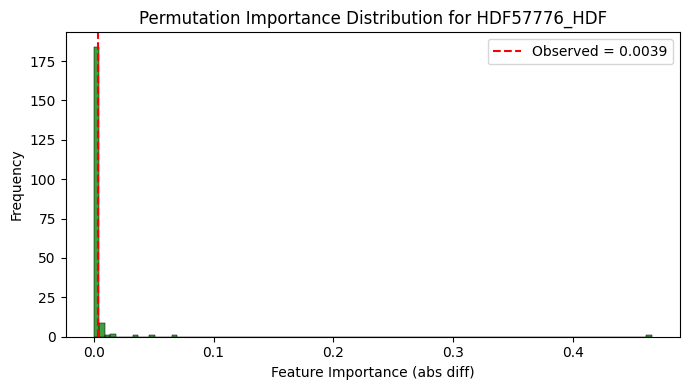

 2. HDF36095_HDF         p = 0.1200


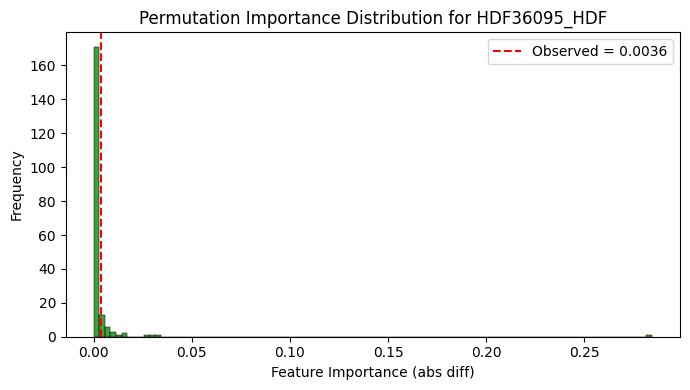

 3. PM35538_PM           p = 0.1350


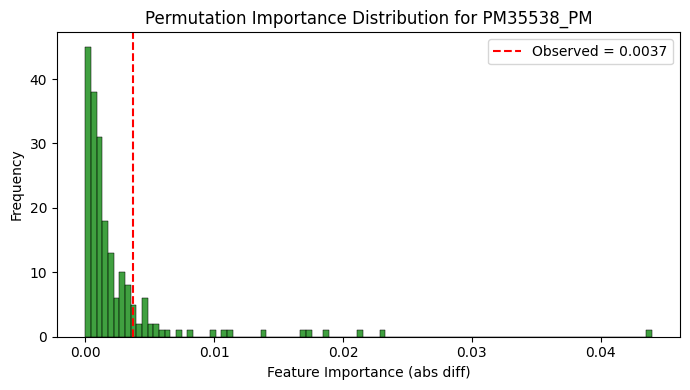

 4. HDF35437_HDF         p = 0.1350


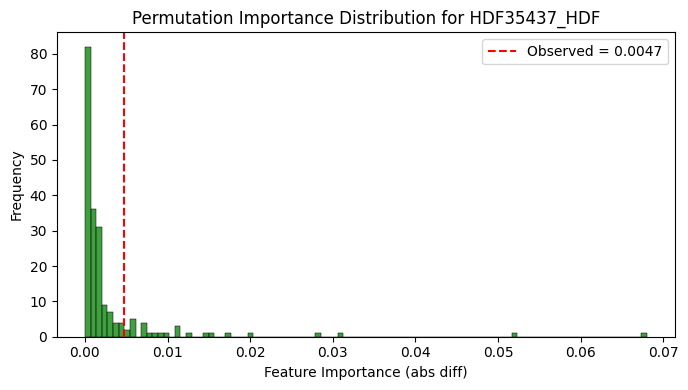

 5. HDF19265_HDF         p = 0.1500


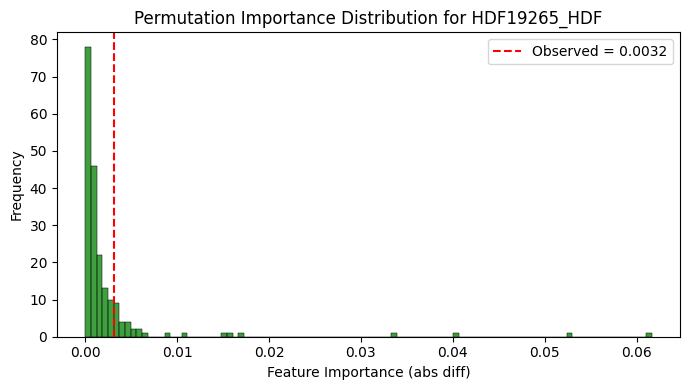

 6. PM36095_PM           p = 0.1550


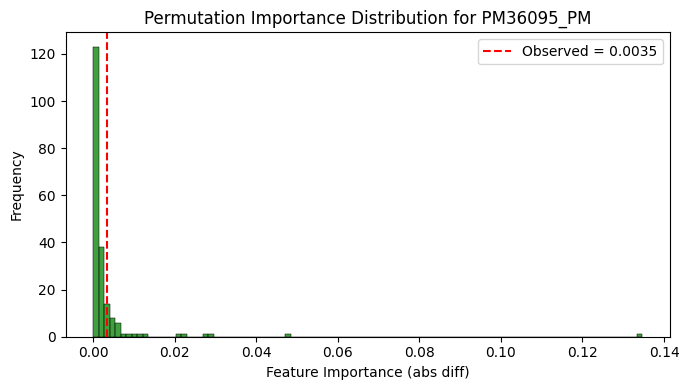

 7. HDF49592_HDF         p = 0.1600


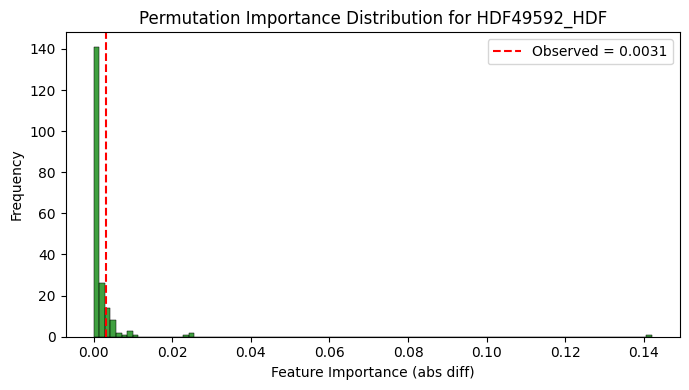

 8. HDF35107_HDF         p = 0.1600


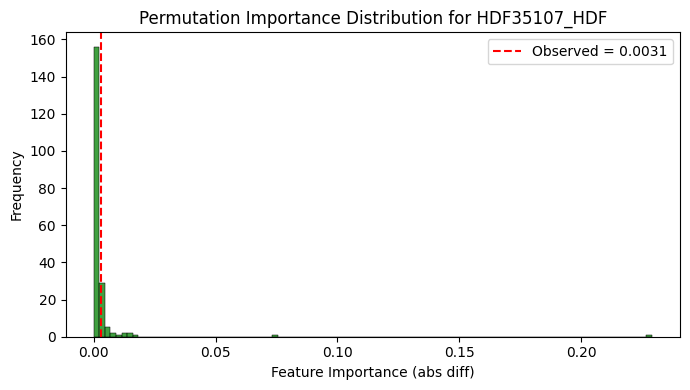

 9. PM31787_PM           p = 0.1650


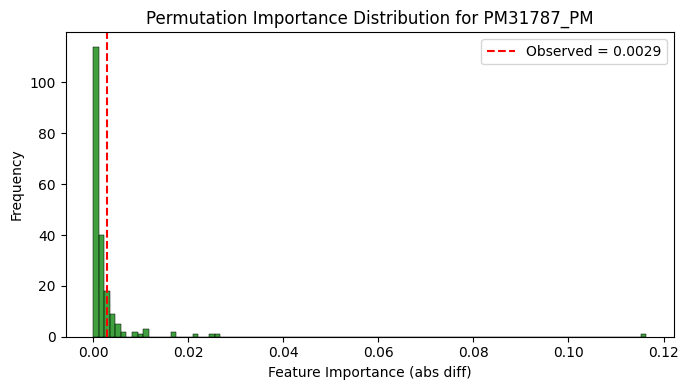

10. HDF27731_HDF         p = 0.1650


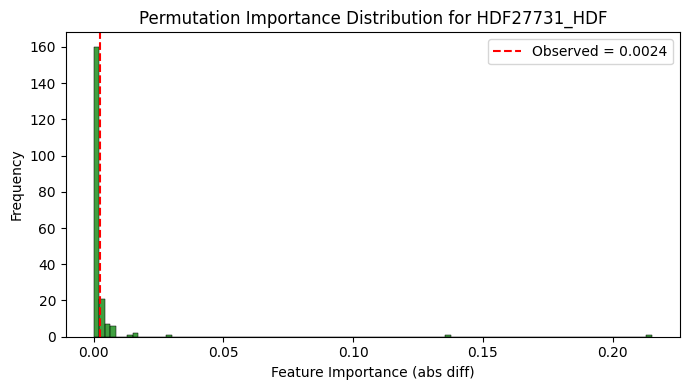

In [184]:
plot_top_pvalue_features(df_pval, all_perm_abs, top_k=10)



🎯 Top 6 features with smallest p_value_abs:

 1. HDF57776_HDF         p = 0.1050


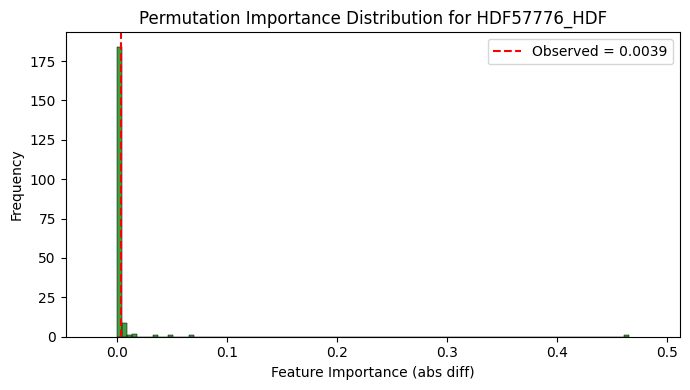

 2. HDF36095_HDF         p = 0.1200


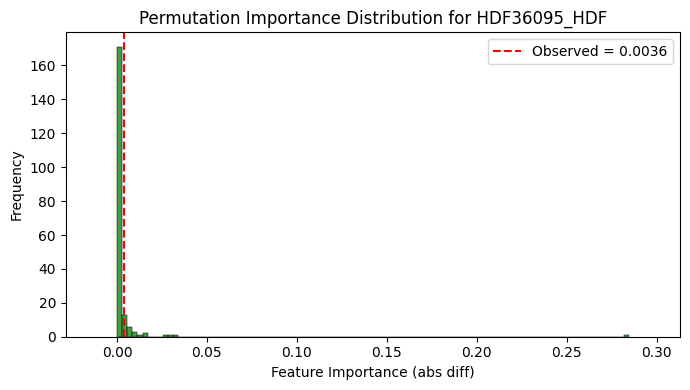

 3. PM35538_PM           p = 0.1350


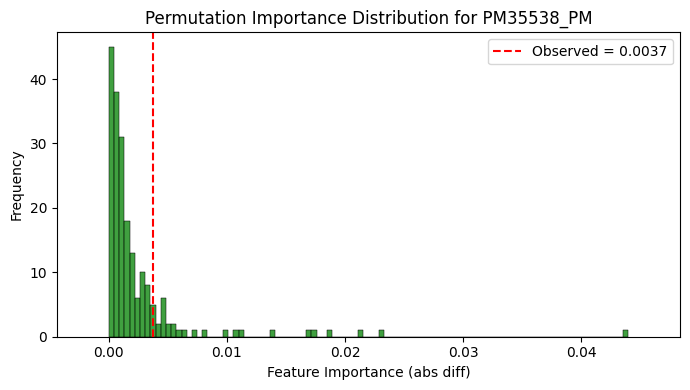

 4. HDF35437_HDF         p = 0.1350


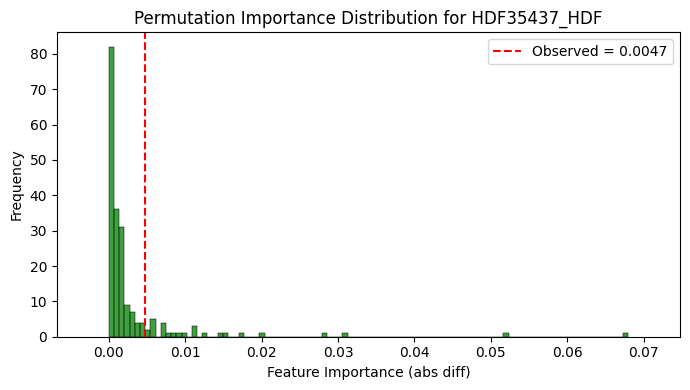

 5. HDF19265_HDF         p = 0.1500


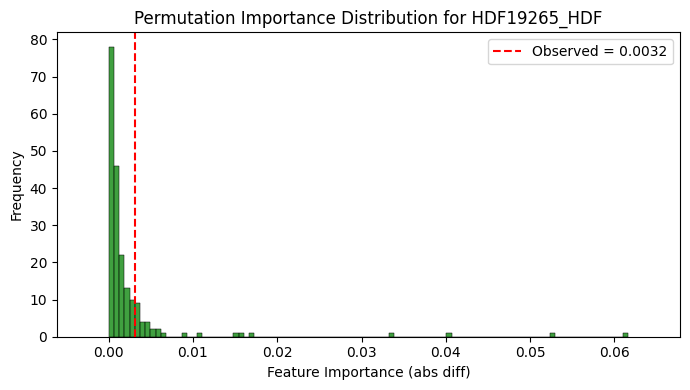

 6. PM36095_PM           p = 0.1550


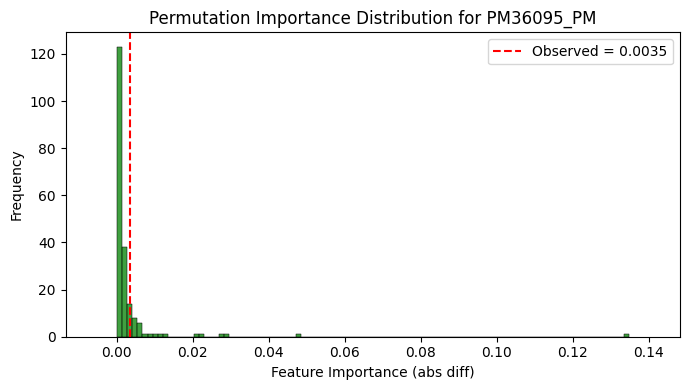

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_permutation_distribution(
    df_pval,
    df_null,
    feature_name,
    bins=30,
    figsize=(7, 4),
    margin_ratio=0.1
):
    # 如果 df_null 没用 index，而是有 name 列，就临时设置索引
    if 'name' in df_null.columns and feature_name not in df_null.index:
        df_null = df_null.set_index('name')

    if feature_name not in df_null.index:
        raise ValueError(f"Feature '{feature_name}' not found in permutation results.")

    # 取观测值
    obs_value = df_pval.loc[df_pval['feature'] == feature_name, 'obs_importance_diff_abs'].values[0]
    # 取 null 分布
    null_dist = df_null.loc[feature_name].values.astype(float)

    plt.figure(figsize=figsize)
    sns.histplot(null_dist, bins=bins, kde=False, color='green')
    plt.axvline(obs_value, color='red', linestyle='--', label=f'Observed = {obs_value:.4f}')
    plt.title(f'Permutation Importance Distribution for {feature_name}')
    plt.xlabel('Feature Importance (abs diff)')
    plt.ylabel('Frequency')
    plt.legend()

    # 横坐标自适应 + 留白
    min_x = min(null_dist.min(), obs_value)
    max_x = max(null_dist.max(), obs_value)
    margin = (max_x - min_x) * margin_ratio
    plt.xlim(min_x - margin, max_x + margin)

    plt.tight_layout()
    plt.show()


def plot_top_pvalue_features(
    df_pval,
    df_null,
    top_k=10,
    pval_column='p_value_abs',
    bins=100,
    figsize=(7, 4)
):
    # 取 p 值最小的 top_k 特征
    top_features = df_pval.sort_values(by=pval_column).head(top_k)['feature'].tolist()

    print(f"\n🎯 Top {top_k} features with smallest {pval_column}:\n")
    for i, f in enumerate(top_features):
        pval = df_pval[df_pval['feature'] == f][pval_column].values[0]
        print(f"{i+1:>2}. {f:<20} p = {pval:.4f}")
        plot_feature_permutation_distribution(df_pval, df_null, f, bins=bins, figsize=figsize)


# 用法：
plot_top_pvalue_features(df_pval, all_perm_abs, top_k=6)



🎯 Top 6 features with smallest p_value_abs:

 1. HDF57776_HDF         p = 0.1050


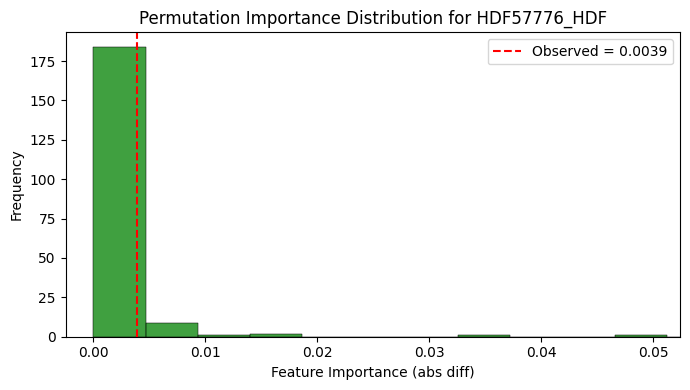

 2. HDF36095_HDF         p = 0.1200


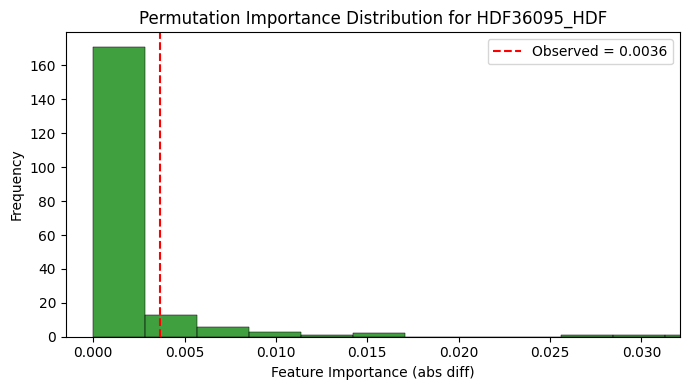

 3. PM35538_PM           p = 0.1350


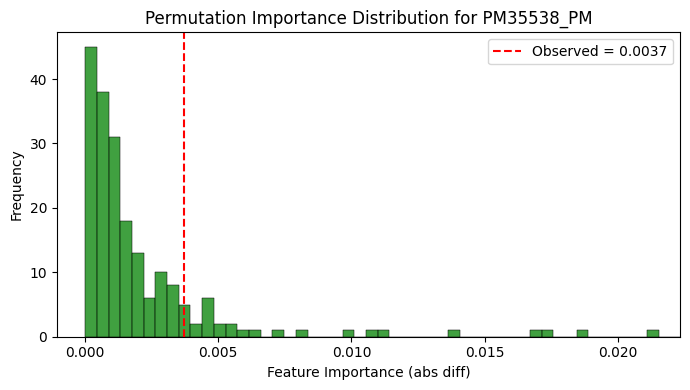

 4. HDF35437_HDF         p = 0.1350


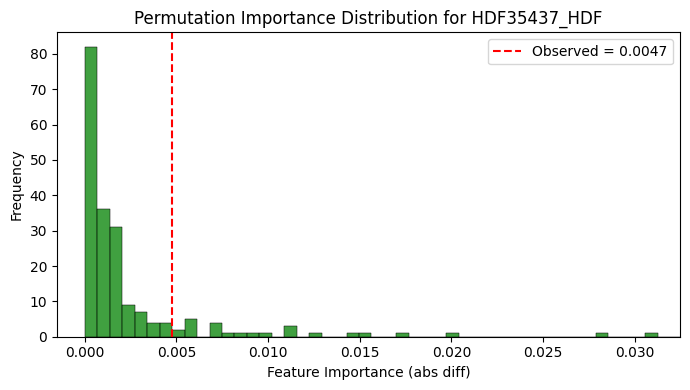

 5. HDF19265_HDF         p = 0.1500


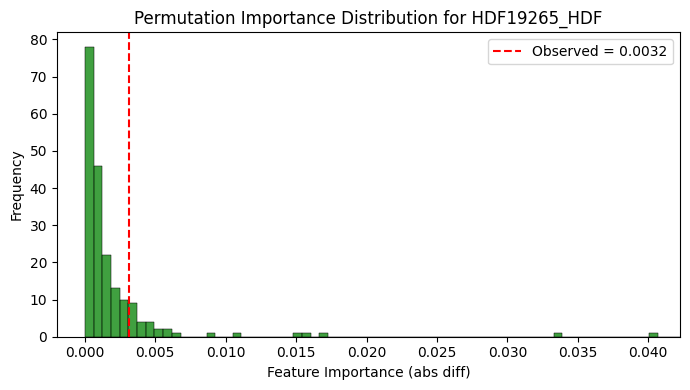

 6. PM36095_PM           p = 0.1550


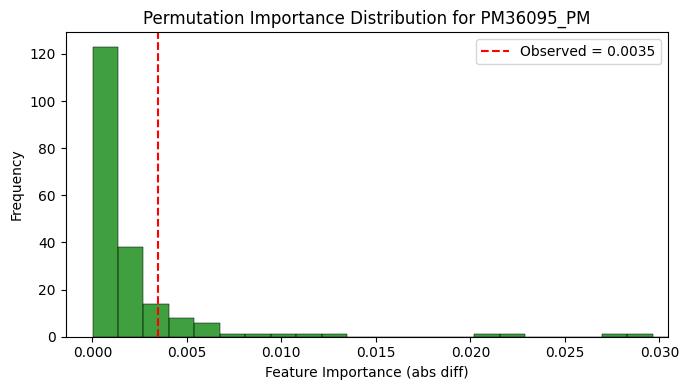

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_feature_permutation_distribution(
    df_pval,
    df_null,
    feature_name,
    bins=1,
    figsize=(7, 4),
    margin_ratio=0.05,
    clip_quantiles=(0.01, 0.99)  # 1%到99%分位数截断
):
    if 'name' in df_null.columns and feature_name not in df_null.index:
        df_null = df_null.set_index('name')

    if feature_name not in df_null.index:
        raise ValueError(f"Feature '{feature_name}' not found in permutation results.")

    obs_value = df_pval.loc[df_pval['feature'] == feature_name, 'obs_importance_diff_abs'].values[0]
    null_dist = df_null.loc[feature_name].values.astype(float)

    # 计算分位数截断范围
    lower_q, upper_q = np.quantile(null_dist, clip_quantiles)
    # 结合观察值，保证观察值不被截断
    min_x = min(lower_q, obs_value)
    max_x = max(upper_q, obs_value)
    margin = (max_x - min_x) * margin_ratio

    plt.figure(figsize=figsize)
    sns.histplot(null_dist, bins=bins, kde=False, color='green')
    plt.axvline(obs_value, color='red', linestyle='--', label=f'Observed = {obs_value:.4f}')
    plt.title(f'Permutation Importance Distribution for {feature_name}')
    plt.xlabel('Feature Importance (abs diff)')
    plt.ylabel('Frequency')
    plt.legend()

    plt.xlim(min_x - margin, max_x + margin)
    plt.tight_layout()
    plt.show()
plot_top_pvalue_features(df_pval, all_perm_abs, top_k=6)


🎯 Top 6 features with smallest p_value_abs:

 1. HDF57776_HDF         p = 0.1050
 2. HDF36095_HDF         p = 0.1200
 3. PM35538_PM           p = 0.1350
 4. HDF35437_HDF         p = 0.1350
 5. HDF19265_HDF         p = 0.1500
 6. PM36095_PM           p = 0.1550


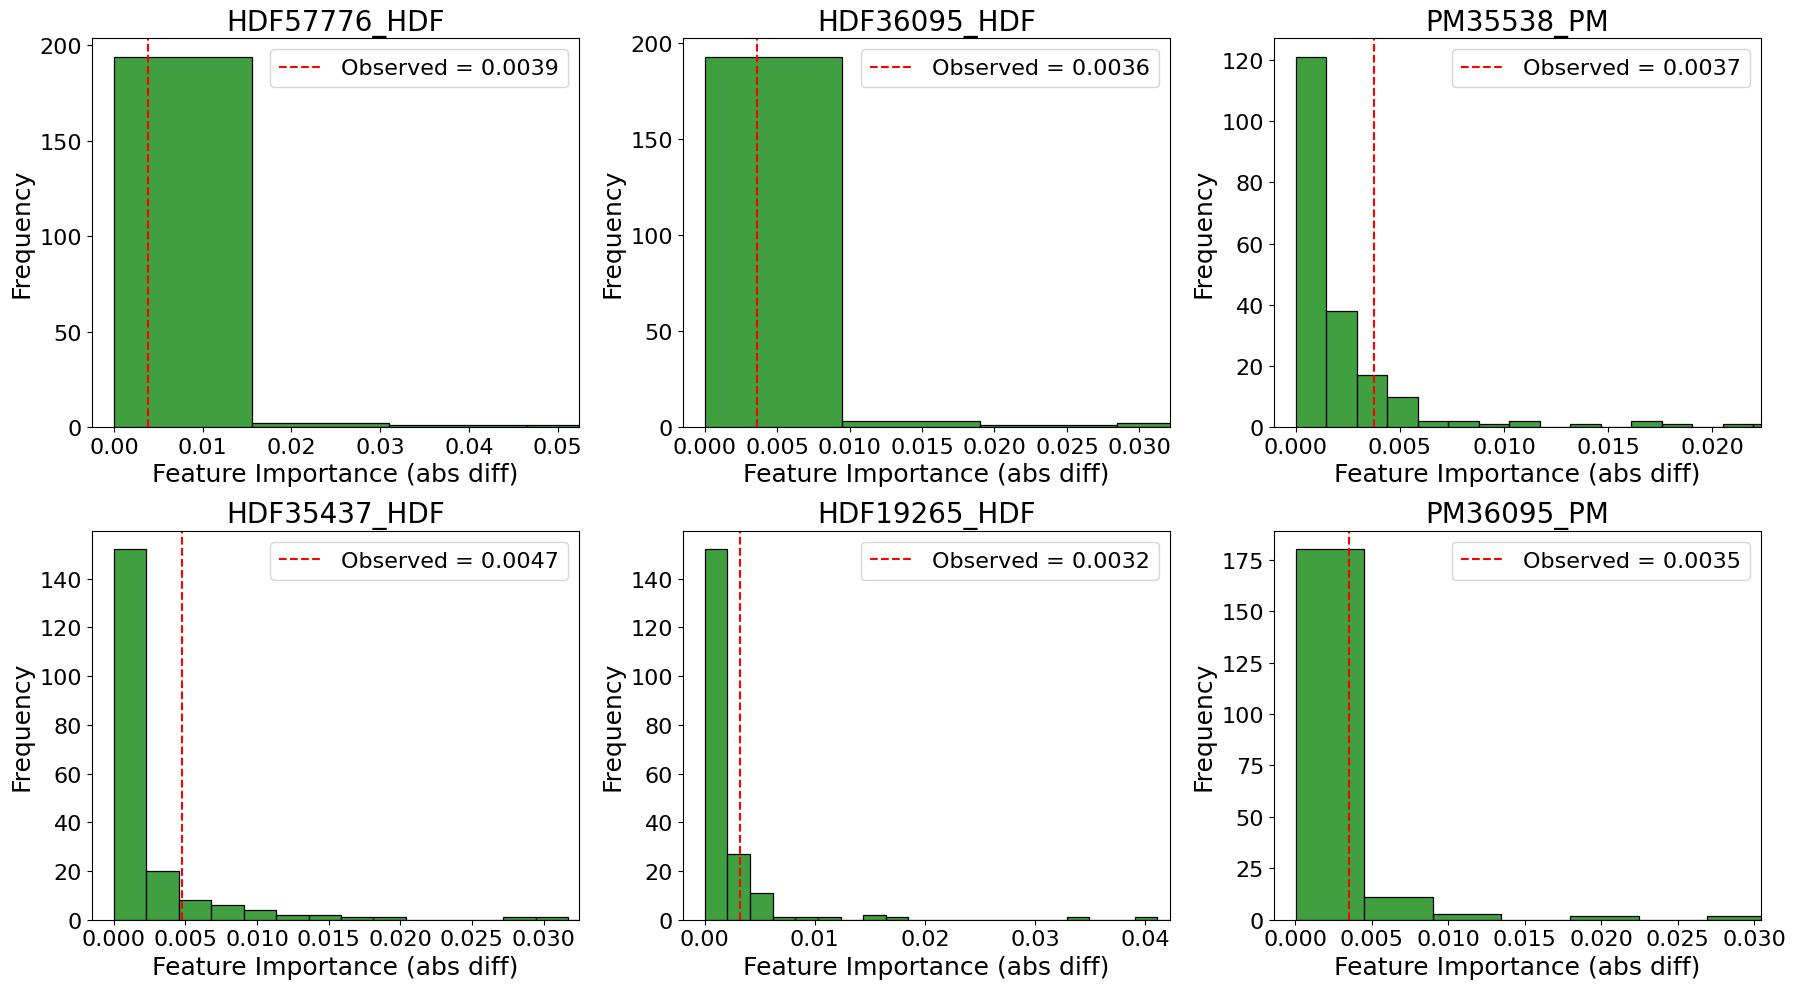

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_feature_permutation_distribution(
    df_pval,
    df_null,
    feature_name,
    ax=None,
    bins=30,
    margin_ratio=0.05,
    clip_quantiles=(0.01, 0.99)
):
    if 'name' in df_null.columns and feature_name not in df_null.index:
        df_null = df_null.set_index('name')

    if feature_name not in df_null.index:
        raise ValueError(f"Feature '{feature_name}' not found in permutation results.")

    obs_value = df_pval.loc[df_pval['feature'] == feature_name, 'obs_importance_diff_abs'].values[0]
    null_dist = df_null.loc[feature_name].values.astype(float)

    lower_q, upper_q = np.quantile(null_dist, clip_quantiles)
    min_x = min(lower_q, obs_value)
    max_x = max(upper_q, obs_value)
    margin = (max_x - min_x) * margin_ratio

    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))

    sns.histplot(null_dist, bins=bins, kde=False, color='green', ax=ax)
    ax.axvline(obs_value, color='red', linestyle='--', label=f'Observed = {obs_value:.4f}')
    ax.set_title(f'{feature_name}', fontsize=20)
    ax.set_xlabel('Feature Importance (abs diff)', fontsize=18)
    ax.set_ylabel('Frequency', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.legend(fontsize=16)
    ax.set_xlim(min_x - margin, max_x + margin)
    return ax

def plot_top_pvalue_features_combined(
    df_pval,
    df_null,
    top_k=6,
    pval_column='p_value_abs',
    bins=30,
    clip_quantiles=(0.01, 0.99),
    figsize=(18, 10)  # 2行3列布局
):
    top_features = df_pval.sort_values(by=pval_column).head(top_k)['feature'].tolist()

    print(f"\n🎯 Top {top_k} features with smallest {pval_column}:\n")
    for i, f in enumerate(top_features):
        pval = df_pval[df_pval['feature'] == f][pval_column].values[0]
        print(f"{i+1:>2}. {f:<20} p = {pval:.4f}")

    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()

    for ax, feature in zip(axes, top_features):
        plot_feature_permutation_distribution(
            df_pval, df_null, feature, ax=ax,
            bins=bins,
            clip_quantiles=clip_quantiles
        )
    for ax in axes[len(top_features):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# 调用示范
plot_top_pvalue_features_combined(df_pval, all_perm_abs, top_k=6)



🎯 Top 6 features with smallest p_value_abs:

 1. HDF57776_HDF         p = 0.1050
 2. HDF36095_HDF         p = 0.1200
 3. PM35538_PM           p = 0.1350
 4. HDF35437_HDF         p = 0.1350
 5. HDF19265_HDF         p = 0.1500
 6. PM36095_PM           p = 0.1550
[INFO] Figure saved to C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\Thesis write up\figures\top6_feature_permutation_distribution.png


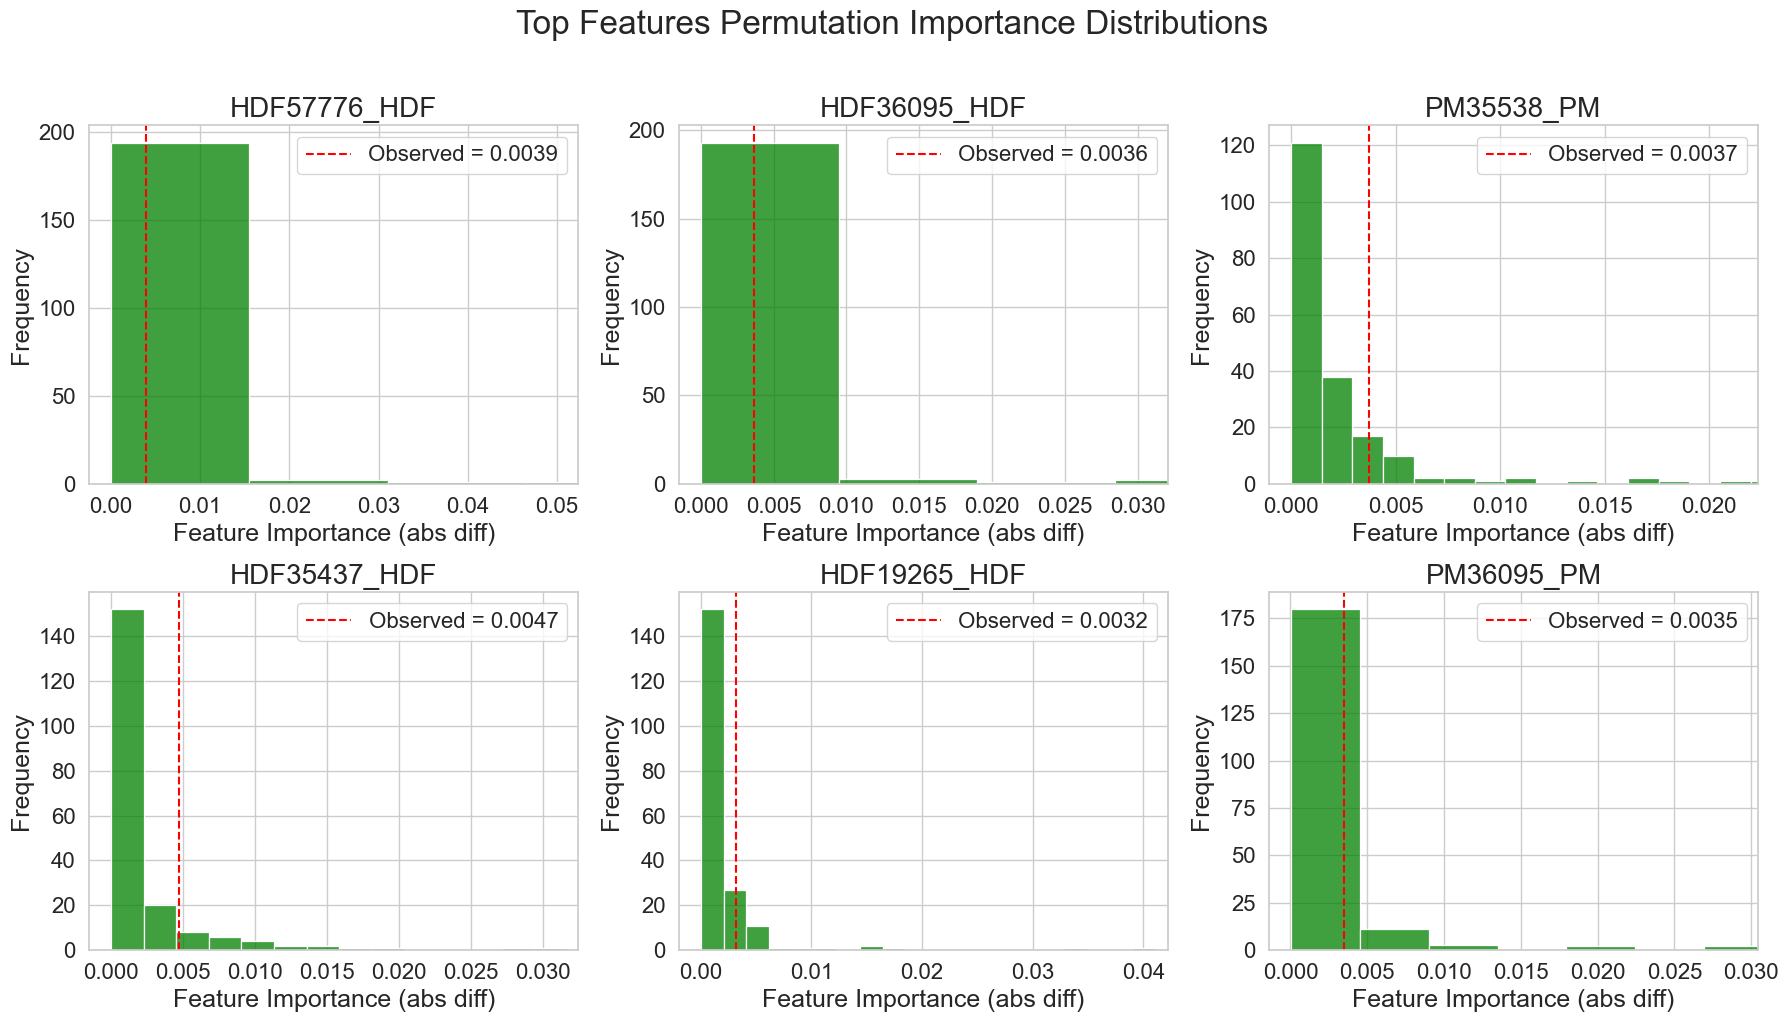

In [55]:
def plot_top_pvalue_features_combined(
    df_pval,
    df_null,
    top_k=6,
    pval_column='p_value_abs',
    bins=30,
    clip_quantiles=(0.01, 0.99),
    figsize=(18, 10),
    save_path=None,
    suptitle="Top Features Permutation Importance Distributions"
):
    top_features = df_pval.sort_values(by=pval_column).head(top_k)['feature'].tolist()

    print(f"\n🎯 Top {top_k} features with smallest {pval_column}:\n")
    for i, f in enumerate(top_features):
        pval = df_pval[df_pval['feature'] == f][pval_column].values[0]
        print(f"{i+1:>2}. {f:<20} p = {pval:.4f}")

    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()

    for ax, feature in zip(axes, top_features):
        plot_feature_permutation_distribution(
            df_pval, df_null, feature, ax=ax,
            bins=bins,
            clip_quantiles=clip_quantiles
        )
    for ax in axes[len(top_features):]:
        ax.axis('off')

    fig.suptitle(suptitle, fontsize=24, y=1.02)
    plt.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"[INFO] Figure saved to {save_path}")

    plt.show()

# 调用示例，指定保存路径
save_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\Thesis write up\figures\top6_feature_permutation_distribution.png"

plot_top_pvalue_features_combined(df_pval, all_perm_abs, top_k=6, save_path=save_path)


In [25]:
print(all_perm_abs.shape)
print(all_perm_abs.head())
print(all_perm_abs.index[:5])
print(all_perm_abs.columns[:5])


(2715, 201)
         name    perm_0    perm_1    perm_2    perm_3    perm_4    perm_5  \
0  PM43027_PM  0.001722  0.206740  0.002428  0.005937  0.001941  0.003284   
1  PM11953_PM  0.001255  0.103943  0.003044  0.003208  0.006960  0.001117   
2  PM38002_PM  0.000709  0.118428  0.000958  0.004020  0.005270  0.004643   
3  PM34404_PM  0.000050  0.077697  0.000989  0.002470  0.006920  0.002641   
4  PM35963_PM  0.001829  0.067646  0.003678  0.000868  0.006844  0.000567   

     perm_6    perm_7    perm_8  ...  perm_190  perm_191  perm_192  perm_193  \
0  0.001266  0.000366  0.000037  ...  0.000573  0.000514  0.000596  0.000307   
1  0.000028  0.001013  0.000431  ...  0.001070  0.003606  0.000350  0.001922   
2  0.000678  0.000636  0.000464  ...  0.001260  0.005743  0.001546  0.000988   
3  0.000218  0.000531  0.001485  ...  0.000556  0.000692  0.002183  0.000019   
4  0.000057  0.001846  0.000608  ...  0.000296  0.001670  0.001330  0.000553   

   perm_194  perm_195  perm_196  perm_197  p

# parallize the whole thing

In [111]:
import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from captum.attr import IntegratedGradients, GradientShap

def Forward_target(model, *args):
    input_data = list(args[:-2])
    target_var = args[-2]
    steps = args[-1]
    outputs_list = []
    for i in range(steps):
        x_step = [input_data[j][i] for j in range(len(input_data))]
        out = model.forward(x_step)
        outputs_list.append(out[target_var])
    return torch.cat(outputs_list, dim=0)


def compute_class_diff_importance(
    model, 
    dataset, 
    target_var, 
    method="IntegratedGradients", 
    steps_or_samples=5, 
    batch_size=64, 
    device='cpu'
):
    model.to(device)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    if method == "IntegratedGradients":
        explainer = IntegratedGradients(lambda *args: Forward_target(model, *args))
    elif method == "GradientShap":
        explainer = GradientShap(lambda *args: Forward_target(model, *args))
    else:
        raise ValueError(f"Unsupported method '{method}'.")

    if dataset.variable_types[target_var] == 'numerical':
        num_class = 1
    else:
        num_class = len(np.unique([y[target_var] for _, y, _ in dataset]))

    aggregated_attributions = [[] for _ in range(num_class)]
    for batch in dataloader:
        dat, _, _ = batch
        x_list = [dat[x].to(device) for x in dat.keys()]
        input_data = tuple([data.unsqueeze(0).requires_grad_() for data in x_list])

        if method == 'IntegratedGradients':
            baseline = tuple(torch.zeros_like(x) for x in input_data)
        elif method == 'GradientShap':
            baseline = tuple(
                torch.cat([torch.zeros_like(x) for _ in range(steps_or_samples)], dim=0)
                for x in input_data
            )

        for target_class in range(num_class):
            if method == 'IntegratedGradients':
                attributions = explainer.attribute(
                    input_data,
                    baseline,
                    additional_forward_args=(target_var, steps_or_samples), 
                    target=target_class,
                    n_steps=steps_or_samples
                )
            elif method == 'GradientShap':
                attributions = explainer.attribute(
                    input_data,
                    baseline,
                    additional_forward_args=(target_var, steps_or_samples), 
                    target=target_class,
                    n_samples=steps_or_samples
                )
            aggregated_attributions[target_class].append(attributions)

    layers = list(dataset.dat.keys())
    processed_attributions = []
    for class_idx in range(len(aggregated_attributions)):
        class_attr = aggregated_attributions[class_idx]
        layer_attributions = []
        for layer_idx in range(len(layers)):
            layer_tensors = [batch_attr[layer_idx] for batch_attr in class_attr]
            attr_concat = torch.cat(layer_tensors, dim=1)
            layer_attributions.append(attr_concat)
        processed_attributions.append(layer_attributions)

    attr_cpu = [[a.cpu() for a in attr_class] for attr_class in processed_attributions]
    imp = [[a.mean(dim=1) for a in attr_class] for attr_class in attr_cpu]

    model.to('cpu')
    df_list = []
    for i in range(num_class):
        for j in range(len(layers)):
            features = dataset.features[layers[j]]
            importances = imp[i][j][0].detach().numpy()
            df_list.append(pd.DataFrame({
                'target_variable': target_var,
                'target_class': i,
                'layer': layers[j],
                'name': features,
                'importance': importances
            }))    
    df_imp = pd.concat(df_list, ignore_index=True)

    if num_class == 2:
        df_0 = df_imp[df_imp['target_class'] == 0].copy()
        df_1 = df_imp[df_imp['target_class'] == 1].copy()
        key_cols = ['target_variable', 'layer', 'name']
        df_0 = df_0.set_index(key_cols)
        df_1 = df_1.set_index(key_cols)

        diff_series = df_1['importance'] - df_0['importance']
        diff_abs = diff_series.abs()
        direction = diff_series.apply(lambda x: '↑ class 1' if x > 0 else ('↑ class 0' if x < 0 else 'none'))

        class_diff = pd.DataFrame({
            'target_variable': df_1.index.get_level_values('target_variable'),
            'layer': df_1.index.get_level_values('layer'),
            'name': df_1.index.get_level_values('name'),
            'importance_diff': diff_series,
            'importance_diff_abs': diff_abs,
            'direction': direction
        }).reset_index(drop=True)
    else:
        class_diff = None

    return class_diff


In [113]:
import copy

def _perm_worker_jupyter(i, whole_dataset, y_orig, model_class, target_var, config_name, n_iter, early_stop_patience,
                         compute_class_diff_fn, method, steps_or_samples, batch_size, obs_diff_idx, obs_diff_abs_idx):
    try:
        dataset_copy = copy.deepcopy(whole_dataset)
        idx = torch.randperm(len(y_orig))
        dataset_copy.ann[target_var] = y_orig[idx]

        tuner = flexynesis.HyperparameterTuning(
            dataset=dataset_copy,
            model_class=model_class,
            target_variables=[target_var],
            config_name=config_name,
            n_iter=n_iter,
            plot_losses=False,
            early_stop_patience=early_stop_patience,
        )
        perm_model, _, _ = tuner.perform_tuning()

        class_diff_perm = compute_class_diff_fn(
            perm_model, dataset_copy, target_var, method, steps_or_samples, batch_size
        )

        perm_signed = class_diff_perm.set_index('name')['importance_diff']
        perm_abs = class_diff_perm.set_index('name')['importance_diff_abs']

        perm_signed = perm_signed.reindex(obs_diff_idx).fillna(0)
        perm_abs = perm_abs.reindex(obs_diff_abs_idx).fillna(0)

        return perm_signed, perm_abs, i
    except Exception as e:
        print(f"[Thread {i}] Failed: {e}")
        empty = pd.Series(0, index=obs_diff_idx)
        return empty, empty, i


In [115]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.notebook import tqdm
import time

def feature_importance_permutation_test_diff_jupyter(
    model,
    whole_dataset,
    target_var="clin",
    method="GradientShap",
    steps_or_samples=10,
    batch_size=32,
    n_permutations=10,
    model_class=None,
    config_name="DirectPred",
    early_stop_patience=4,
    n_iter=2,
    compute_class_diff_fn=compute_class_diff_importance,
    n_workers=4
):
    start_time = time.time()
    print(f"[INFO] Permutation test started at {time.strftime('%Y-%m-%d %H:%M:%S')}")

    class_diff_obs = compute_class_diff_fn(
        model, whole_dataset, target_var, method, steps_or_samples, batch_size
    )
    obs_diff = class_diff_obs.set_index('name')['importance_diff']
    obs_diff_abs = class_diff_obs.set_index('name')['importance_diff_abs']
    direction = class_diff_obs.set_index('name')['direction']

    all_perm_signed = pd.DataFrame(index=obs_diff.index)
    all_perm_abs = pd.DataFrame(index=obs_diff_abs.index)

    y_orig = whole_dataset.ann[target_var].clone()

    with ThreadPoolExecutor(max_workers=n_workers) as executor:
        futures = [
            executor.submit(
                _perm_worker_jupyter, i, whole_dataset, y_orig, model_class, target_var, config_name,
                n_iter, early_stop_patience, compute_class_diff_fn, method, steps_or_samples, batch_size,
                obs_diff.index, obs_diff_abs.index
            )
            for i in range(n_permutations)
        ]

        for future in tqdm(as_completed(futures), total=len(futures), desc="Running Permutations"):
            perm_signed, perm_abs, i = future.result()
            all_perm_signed[f"perm_{i}"] = perm_signed
            all_perm_abs[f"perm_{i}"] = perm_abs

    whole_dataset.ann[target_var] = y_orig

    ge_abs = (all_perm_abs.ge(obs_diff_abs, axis=0)).sum(axis=1)
    p_value_abs = ge_abs / n_permutations

    ge_signed = (all_perm_signed.ge(obs_diff, axis=0)).sum(axis=1)
    p_value_signed = ge_signed / n_permutations

    df_pval = pd.DataFrame({
        'feature': obs_diff.index,
        'obs_importance_diff': obs_diff.values,
        'obs_importance_diff_abs': obs_diff_abs.values,
        'direction': direction.values,
        'p_value_abs': p_value_abs.values,
        'p_value_signed': p_value_signed.values
    }).reset_index(drop=True)

    end_time = time.time()
    print(f"[INFO] Permutation test finished at {time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"[INFO] Total elapsed time: {end_time - start_time:.2f} seconds")

    return df_pval, all_perm_abs, all_perm_signed, class_diff_obs


In [127]:
df_pval, all_perm_abs, all_perm_signed, class_diff_obs = feature_importance_permutation_test_diff_jupyter(
    model=model,
    whole_dataset=whole_dataset,
    target_var="clin",
    method="GradientShap",
    steps_or_samples=10,
    batch_size=32,
    n_permutations=3,
    model_class=flexynesis.DirectPred,
    config_name="DirectPred",
    early_stop_patience=4,
    n_iter=1,
    compute_class_diff_fn=compute_class_diff_importance,
    n_workers=2  # Jupyter建议小线程数
)
print(df_pval.head())


Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.7823624610900879     │
│         val_loss          │    0.7823624610900879     │
└───────────────────────────┴───────────────────────────┘


Tuning Progress: 100%|██████████| 1/1 [00:34<00:00, 34.87s/it, Iteration=1, Best Loss=0.782]


[INFO] current best val loss: 0.7823624610900879; best params: {'latent_dim': 66, 'hidden_dim_factor': 0.47214542285909544, 'lr': 0.0021159211938971655, 'supervisor_hidden_dim': 37, 'epochs': 300, 'batch_size': 128} since 0 hpo iterations
[INFO] Permutation test finished at 2025-07-16 01:33:55
[INFO] Total elapsed time: 77.03 seconds
      feature  obs_importance_diff  obs_importance_diff_abs  direction  \
0  PM43027_PM             0.002740                 0.002740  ↑ class 1   
1  PM11953_PM            -0.000392                 0.000392  ↑ class 0   
2  PM38002_PM             0.002005                 0.002005  ↑ class 1   
3  PM34404_PM            -0.001513                 0.001513  ↑ class 0   
4  PM35963_PM             0.001946                 0.001946  ↑ class 1   

   p_value_abs  p_value_signed  
0     0.000000        0.000000  
1     0.666667        1.000000  
2     0.333333        0.333333  
3     0.333333        0.666667  
4     0.333333        0.333333  


In [129]:
df_pval

,feature,obs_importance_diff,obs_importance_diff_abs,direction,p_value_abs,p_value_signed
0,PM43027_PM,0.002740,0.002740,↑ class 1,0.000000,0.000000
1,PM11953_PM,-0.000392,0.000392,↑ class 0,0.666667,1.000000
2,PM38002_PM,0.002005,0.002005,↑ class 1,0.333333,0.333333
3,PM34404_PM,-0.001513,0.001513,↑ class 0,0.333333,0.666667
4,PM35963_PM,0.001946,0.001946,↑ class 1,0.333333,0.333333
...,...,...,...,...,...,...
2710,HDF62636_HDF,-0.006763,0.006763,↑ class 0,0.000000,1.000000
2711,HDF62664_HDF,0.001516,0.001516,↑ class 1,0.000000,0.000000
2712,HDF62716_HDF,0.000352,0.000352,↑ class 1,0.666667,0.666667
2713,HDF62719_HDF,0.000247,0.000247,↑ class 1,0.666667,0.000000


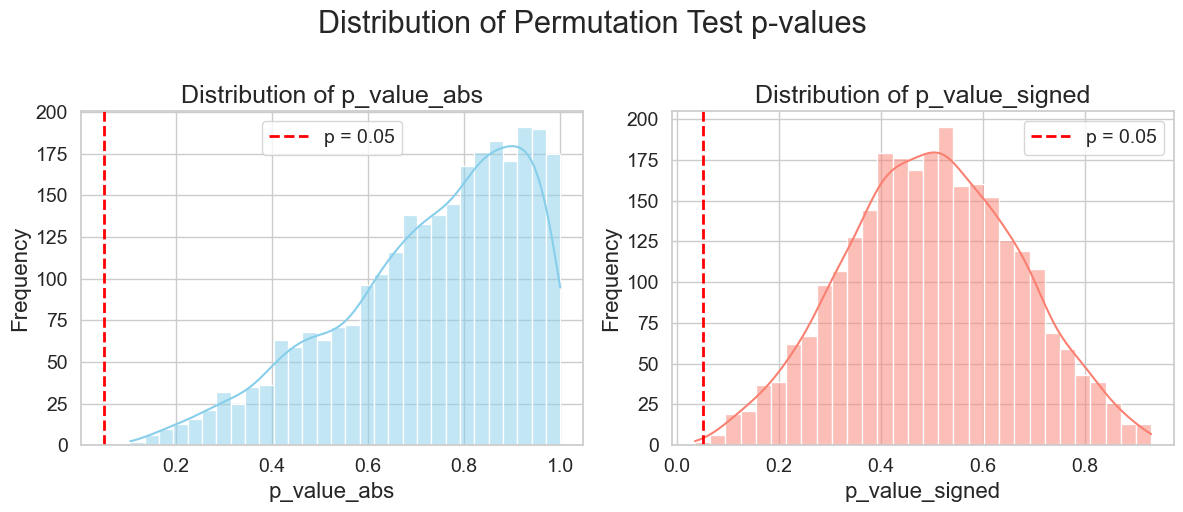

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(12, 5))

title_fontsize = 18
label_fontsize = 16
ticks_fontsize = 14

plt.subplot(1, 2, 1)
sns.histplot(df_pval["p_value_abs"], bins=30, kde=True, color='skyblue')
plt.axvline(0.05, color='red', linestyle='--', linewidth=2, label='p = 0.05')
plt.title("Distribution of p_value_abs", fontsize=title_fontsize)
plt.xlabel("p_value_abs", fontsize=label_fontsize)
plt.ylabel("Frequency", fontsize=label_fontsize)
plt.xticks(fontsize=ticks_fontsize)
plt.yticks(fontsize=ticks_fontsize)
plt.legend(fontsize=14)

plt.subplot(1, 2, 2)
sns.histplot(df_pval["p_value_signed"], bins=30, kde=True, color='salmon')
plt.axvline(0.05, color='red', linestyle='--', linewidth=2, label='p = 0.05')
plt.title("Distribution of p_value_signed", fontsize=title_fontsize)
plt.xlabel("p_value_signed", fontsize=label_fontsize)
plt.ylabel("Frequency", fontsize=label_fontsize)
plt.xticks(fontsize=ticks_fontsize)
plt.yticks(fontsize=ticks_fontsize)
plt.legend(fontsize=14)

plt.suptitle("Distribution of Permutation Test p-values", fontsize=22, y=1.02)

plt.tight_layout()

save_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\Thesis write up\figures\p_value_distribution.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()


In [131]:
all_perm_abs

,perm_1,perm_0,perm_2
name,,,
PM43027_PM,0,0.001203,0.000422
PM11953_PM,0,0.003734,0.001632
PM38002_PM,0,0.002468,0.000988
PM34404_PM,0,0.001898,0.000100
PM35963_PM,0,0.003089,0.000729
...,...,...,...
HDF62636_HDF,0,0.002569,0.000640
HDF62664_HDF,0,0.001374,0.000308
HDF62716_HDF,0,0.003339,0.000527


In [133]:
class_diff_obs

,target_variable,layer,name,importance_diff,importance_diff_abs,direction
0,clin,PM,PM43027_PM,0.002740,0.002740,↑ class 1
1,clin,PM,PM11953_PM,-0.000392,0.000392,↑ class 0
2,clin,PM,PM38002_PM,0.002005,0.002005,↑ class 1
3,clin,PM,PM34404_PM,-0.001513,0.001513,↑ class 0
4,clin,PM,PM35963_PM,0.001946,0.001946,↑ class 1
...,...,...,...,...,...,...
2710,clin,HDF,HDF62636_HDF,-0.006763,0.006763,↑ class 0
2711,clin,HDF,HDF62664_HDF,0.001516,0.001516,↑ class 1
2712,clin,HDF,HDF62716_HDF,0.000352,0.000352,↑ class 1
2713,clin,HDF,HDF62719_HDF,0.000247,0.000247,↑ class 1



🎯 Top 10 features with smallest p_value_abs:

 1. PM43027_PM           p = 0.0000


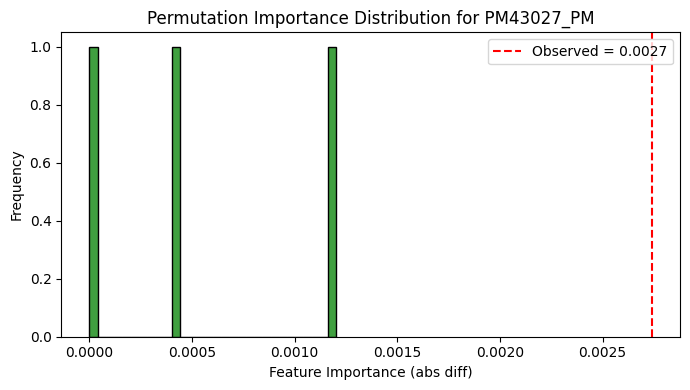

 2. PM41325_PM           p = 0.0000


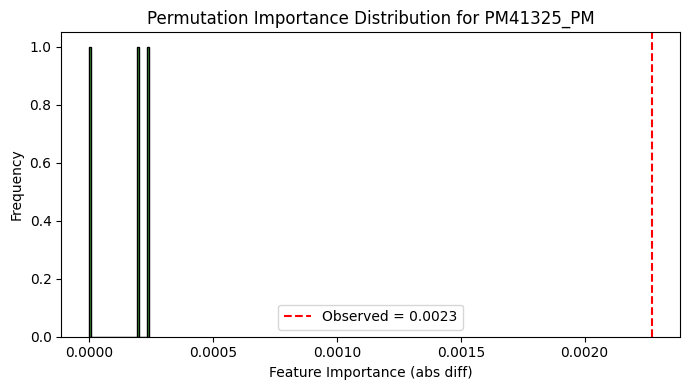

 3. HDF15765_HDF         p = 0.0000


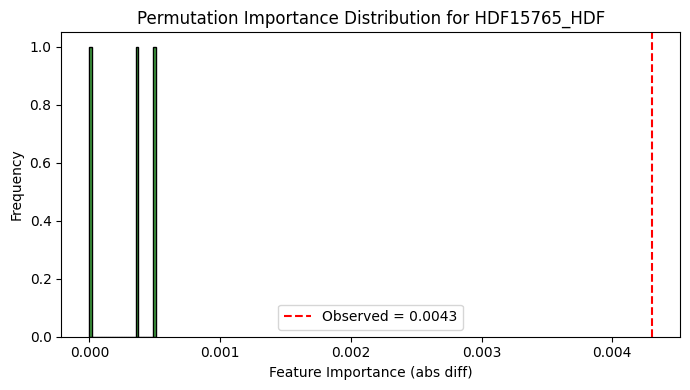

 4. HDF01552_HDF         p = 0.0000


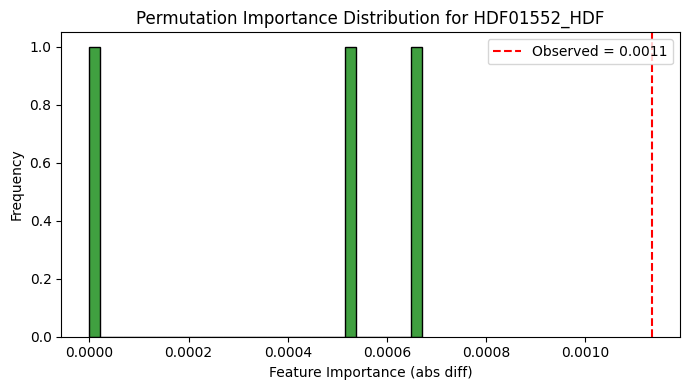

 5. LPC[FA22:4]_LD       p = 0.0000


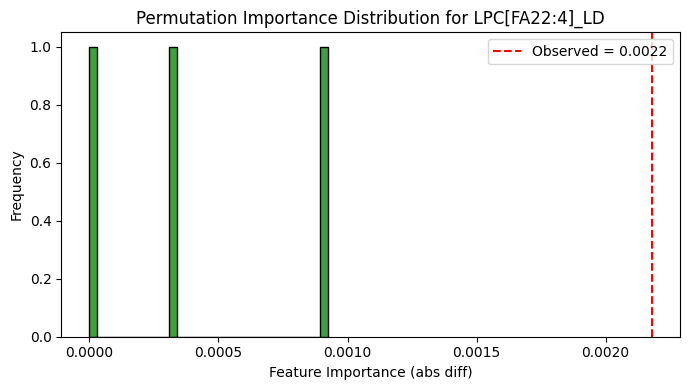

 6. PM42154_PM           p = 0.0000


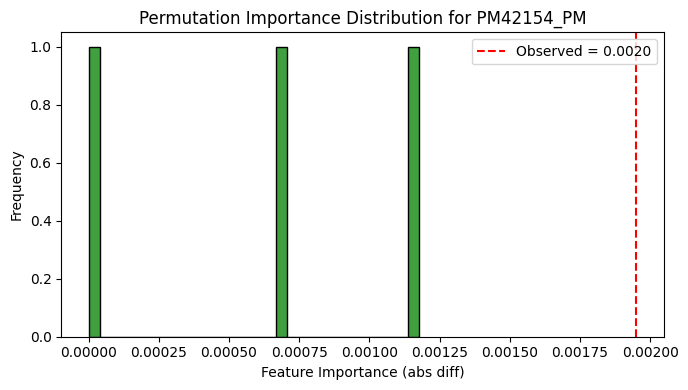

 7. PM42286_PM           p = 0.0000


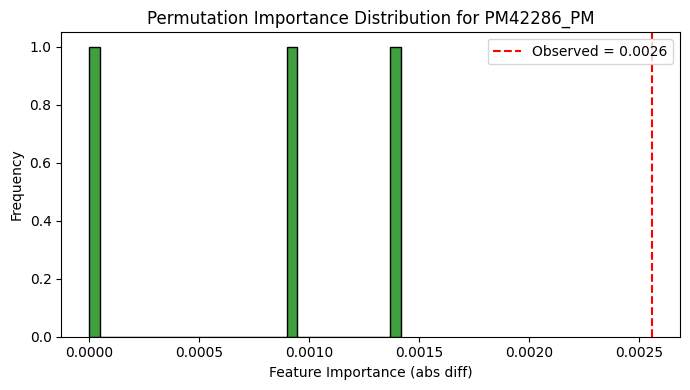

 8. HDF18467_HDF         p = 0.0000


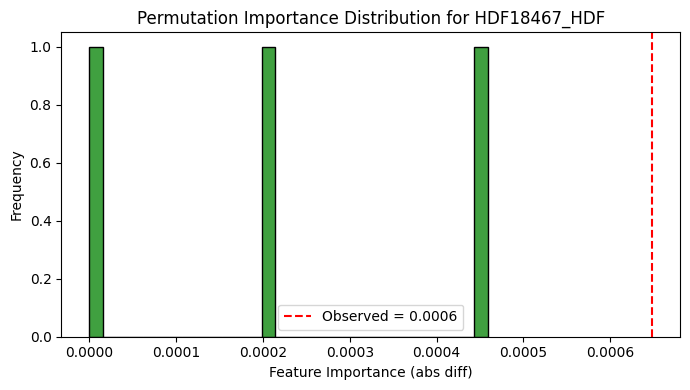

 9. PM40803_PM           p = 0.0000


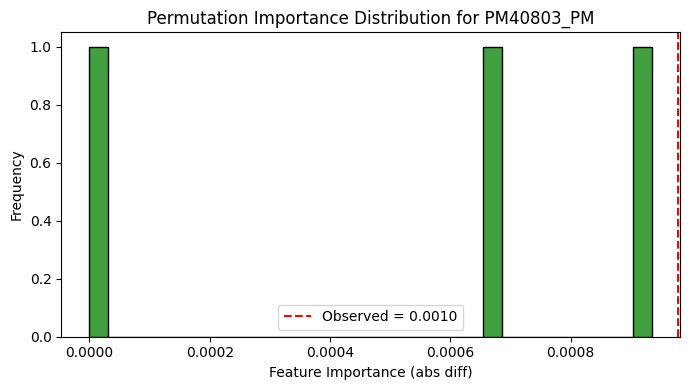

10. HDF39831_HDF         p = 0.0000


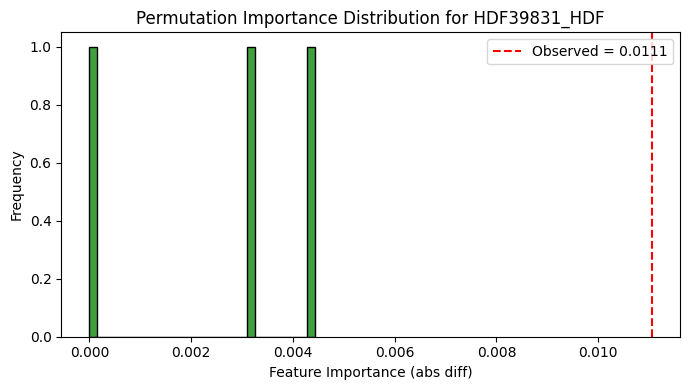

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_permutation_distribution(
    df_pval,
    df_null,
    feature_name,
    bins=30,
    figsize=(7, 4)
):
    if feature_name not in df_null.index:
        raise ValueError(f"Feature '{feature_name}' not found in permutation results.")
    
    obs_value = df_pval.loc[df_pval['feature'] == feature_name, 'obs_importance_diff_abs'].values[0]
    null_dist = df_null.loc[feature_name].values  # permutation values

    plt.figure(figsize=figsize)
    sns.histplot(null_dist, bins=bins, kde=False, color='green')
    plt.axvline(obs_value, color='red', linestyle='--', label=f'Observed = {obs_value:.4f}')
    plt.title(f'Permutation Importance Distribution for {feature_name}')
    plt.xlabel('Feature Importance (abs diff)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_top_pvalue_features(
    df_pval,
    df_null,
    top_k=10,
    pval_column='p_value_abs',
    bins=30,
    figsize=(7, 4)
):
    # 按照 p 值从小到大排序，提取 top k 个特征名
    top_features = df_pval.sort_values(by=pval_column).head(top_k)['feature'].tolist()

    print(f"\n🎯 Top {top_k} features with smallest {pval_column}:\n")
    for i, f in enumerate(top_features):
        pval = df_pval[df_pval['feature'] == f][pval_column].values[0]
        print(f"{i+1:>2}. {f:<20} p = {pval:.4f}")
        plot_feature_permutation_distribution(df_pval, df_null, f, bins=bins, figsize=figsize)

plot_top_pvalue_features(df_pval, all_perm_abs, top_k=10)
